<div style="text-align: center;">
  <h3>Time Series Analysis</h3>
  <h5>Formative Assessment 1</h5>
  <h5><u>By Romand Lansangan</u></h5>
</div>

---

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [33]:
df = pd.read_csv('Advertising and Sales.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column                Non-Null Count  Dtype
---  ------                --------------  -----
 0   Store                 10 non-null     int64
 1   TV Ad ($k)            10 non-null     int64
 2   Radio Ad ($k)         10 non-null     int64
 3   Social Media Ad ($k)  10 non-null     int64
 4   Discounts (%)         10 non-null     int64
 5   Sales ($k)            10 non-null     int64
dtypes: int64(6)
memory usage: 612.0 bytes
None


,Store,TV Ad ($k),Radio Ad ($k),Social Media Ad ($k),Discounts (%),Sales ($k)
0,1,230,37,22,5,650
1,2,44,39,10,7,270
2,3,17,45,12,10,180
3,4,151,41,24,6,500
4,5,180,10,15,8,525


In [34]:
import statsmodels.api as sm

response = 'Sales ($k)' 
Y = df[response]
X = df.drop(columns=response)
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:             Sales ($k)   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.976
Method:                 Least Squares   F-statistic:                     73.73
Date:                Fri, 19 Sep 2025   Prob (F-statistic):           0.000499
Time:                        22:16:55   Log-Likelihood:                -43.142
No. Observations:                  10   AIC:                             98.28
Df Residuals:                       4   BIC:                             100.1
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
const                  297.9210 

Multiple linear regression with all the variables (except "Sales") included:

$$
\text{Sales}_{(k)} \;=\; \\ 297.921 \\
\;-\; 3.758 \cdot \text{Store} \\
\;+\; 1.7255 \cdot \text{TV Ad (\$k)} \\ 
\;-\; 0.7295 \cdot \text{Radio Ad(\$k)} \\ 
\;+\; 3.3007 \cdot \text{Social Media Ad(\$k)} \\
\;-\; 14.9212 \cdot \text{Discounts (\%)} 
$$

Although the Adj R-Sq is excellent, this will not do for the final model since most of the p-values of coeficients are not significant. For this reason, a stepwise selection is imperative.

#### Stepwise Selection

In [35]:
def forward_selection(df, response, model=None, enter_threshold=0.05):
    all_cols = df.drop(columns=response).columns

    if model is not None:
        selected_cols = [c for c in model.params.index if c != "const"]
    else:
        selected_cols = []

    all_cols_not_selected = set(all_cols) - set(selected_cols)

    model_select = model
    col_added = None
    best_sse_reduction = 0.0

    # baseline SSE (if no model yet, use total variance)
    if model is not None:
        baseline_sse = sum(model.resid ** 2)
    else:
        baseline_sse = sum((df[response] - df[response].mean()) ** 2)

    for col in all_cols_not_selected:
        cols_to_train = selected_cols + [col]
        X = sm.add_constant(df[cols_to_train], has_constant="add")
        y = df[response]

        model_current = sm.OLS(y, X).fit()
        sse_current = sum(model_current.resid ** 2)
        sse_reduction = baseline_sse - sse_current

        pval = model_current.pvalues[col]

        if pval < enter_threshold and sse_reduction > best_sse_reduction:
            model_select = model_current
            col_added = col
            best_sse_reduction = sse_reduction

    if col_added is None:
        print("None was selected")
        return None
    else:
        print(f"`{col_added}` was selected (p < {enter_threshold}, SSE reduction = {best_sse_reduction:.2f})")
        return model_select


def backward_selection(df, model, exit_threshold=0.10):
    response = model.model.endog_names
    selected_cols = [c for c in model.params.index if c != "const"]

    baseline_sse = sum(model.resid ** 2)

    model_select = model
    col_removed = None
    min_sse_increase = np.inf

    for col in selected_cols:
        cols_to_train = list(set(selected_cols) - {col})
        X = sm.add_constant(df[cols_to_train], has_constant="add")
        y = df[response]

        model_current = sm.OLS(y, X).fit()
        sse_current = sum(model_current.resid ** 2)
        sse_increase = sse_current - baseline_sse

        pval = model.pvalues[col]

        if pval > exit_threshold and sse_increase < min_sse_increase:
            model_select = model_current
            col_removed = col
            min_sse_increase = sse_increase

    if col_removed is None:
        print("None was removed")
        return None
    else:
        print(f"`{col_removed}` was removed (p > {exit_threshold}, SSE increase = {min_sse_increase:.2f})")
        return model_select



def stepwise_selection(df, response, enter_threshold=0.05, exit_threshold=0.10):
    print("Creating Initial Model")
    model = forward_selection(df, response, enter_threshold=enter_threshold)

    if model is None:
        print("No variables entered. Empty model.")
        return None

    while True:
        model_changed = False

        # Forward step
        print("Running Forward Selection")
        new_model = forward_selection(df, response, model=model, enter_threshold=enter_threshold)
        if new_model is not None:
            model = new_model
            model_changed = True

        # Backward step
        print("Running Backward Selection")
        new_model = backward_selection(df, model, exit_threshold=exit_threshold)
        if new_model is not None:
            model = new_model
            model_changed = True

        # Stop if no change in this cycle
        if not model_changed:
            break

    return model


Basically what this function does is for every stage, it picks the best variable that reduces the Sum of Squares (SSE) the most and meets a certain threshold of p-value. 

In [36]:
model = stepwise_selection(df, response='Sales ($k)')
model.summary()

Creating Initial Model
`TV Ad ($k)` was selected (p < 0.05, SSE reduction = 295189.75)
Running Forward Selection
`Discounts (%)` was selected (p < 0.05, SSE reduction = 4863.48)
Running Backward Selection
None was removed
Running Forward Selection
None was selected
Running Backward Selection
None was removed


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sales ($k)   R-squared:                       0.984
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     218.8
Date:                Fri, 19 Sep 2025   Prob (F-statistic):           4.90e-07
Time:                        22:16:55   Log-Likelihood:                -45.058
No. Observations:                  10   AIC:                             96.12
Df Residuals:                       7   BIC:                             97.02
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           276.0688     55.267      4.995      0.002     145.384     406.754
TV Ad ($k)        1.9469      0.173     11.266      0.000       1.538       2.356
Discounts (%)   -14.3261      5.379     -2.663      0.032     -27.045      -1.607
==============================================================================
Omnibus:                       14.182   Durbin-Watson:                   2.505
Prob(Omnibus):                  0.001   Jarque-Bera (JB):                7.083
Skew:                          -1.775   Prob(JB):                       0.0290
Kurtosis:                       5.098   Cond. No.                         890.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Reduced Model
After Stepwise Selection, the final model will be:

$$
\text{Sales}_{(\$ k)} \;=\; 276.0688 
\;+\; 1.7255 \cdot \text{TV Ad  (\$ k)} 
\;-\; 14.9212 \cdot \text{Discounts (\%)} 
$$


- Intercept (276.0688 ) - does not have a practical application but can be thought of as the value of Sales when there's no spending for `TV Ad` and `Discounts`.
- `Tv Ad` (1.7255) - it means that for every unit (\$k) increase of `Tv Ad`, `Sales` will increase by about 1.7255 unit (\$ k). Also, since p-value<0.05, `Tv Ad` significantly affects `Sales`.
- `Discounts` (-14.9212) - it means that for every unit (\%) increase of `Tv Ad`, `Sales` will decrease by about 14.9212 unit (\$ k). Also, since p-value>0.05, `Discounts` does not significantly affect `Sales`.


#### Comparing with Total Model
It is clear that the **Reduced Model is simpler and better model than the Total Model** due to:
- Less paramaters - including intercept, the Total Model has 6 parameters. This was reduced to 3 parameters in Reduced Model, making it easier to interpret and understand.
- Overfitting is less likely - with simpler model, the Reduced Model reduce the risk of overfitting compared to a more complex Total Model.
- Better Adj. R-Sq - The Adj. R-Sq of Total Model is about 0.976 while the same metric is about 0.980 in Reduced Model. 

Overall, this comparison sheds light on the idea that a more complex model does not necessarily mean a better preditive power.

### Assumption Checking

In [37]:
sns.set_theme()
plt.rcParams['figure.facecolor'] = 'lightgrey'
plt.rcParams['axes.facecolor'] = 'lightgrey'
plt.rcParams['font.family'] = 'serif'

#### Linearity

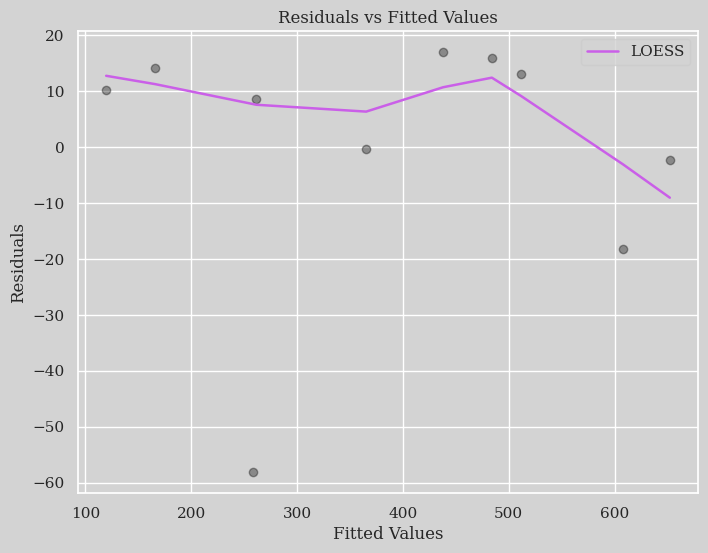

In [38]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))

sns.regplot(x=model.predict(), 
            y=model.resid, 
            scatter_kws={'alpha':0.35, 'color' : "black"}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False)

plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()

plt.show()

The curved shape of the LOESS (purple line) indicates a vilation in linearity since we expect the residuals to be randomly scattered around zero and the LOESS to be relatively flat, but this is not the case in plot. This imply that there's an important non-linear relationship between the predictors and the response that the current linear model is failing to account for. Since the relationship may not be linear, this fact implore us to try out some transformation or add additional term (like polynomial terms) to the model. 

#### Normality of Residuals

In [39]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(model.resid.to_frame())
standardized_resid = scaler.transform(model.resid.to_frame()).squeeze()
standardized_resid_sorted = np.sort(standardized_resid)

normal_theo = np.sort(np.random.normal(0, 1, len(standardized_resid)));

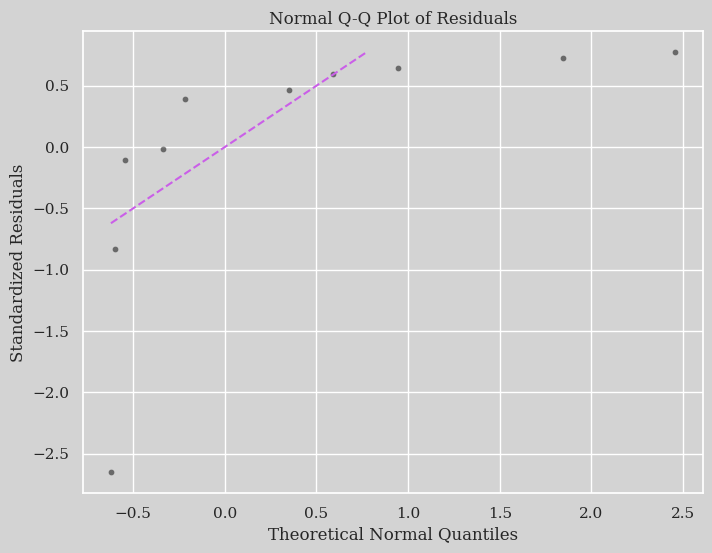

In [40]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 6))


sns.scatterplot(x=normal_theo,
                y=standardized_resid_sorted,
                color="black",
                ax=ax,
                alpha=0.5,
                s=20)

line_coords = np.linspace(min(normal_theo), max(standardized_resid_sorted))

ax.plot(line_coords, line_coords, color='#ca5fe8', linestyle="--") 


ax.set_title('Normal Q-Q Plot of Residuals')
ax.set_xlabel('Theoretical Normal Quantiles')
ax.set_ylabel('Standardized Residuals');

Normality of residuals was also violated since the Standardized residuals does not follow the linear line (shaded purple). There's a particular S-Shape pattern however that has formed in the residuals which is an indicator skewness in residuals rather than normal distribution.

Text(0.5, 0.98, 'Standardized Residual Distribution')

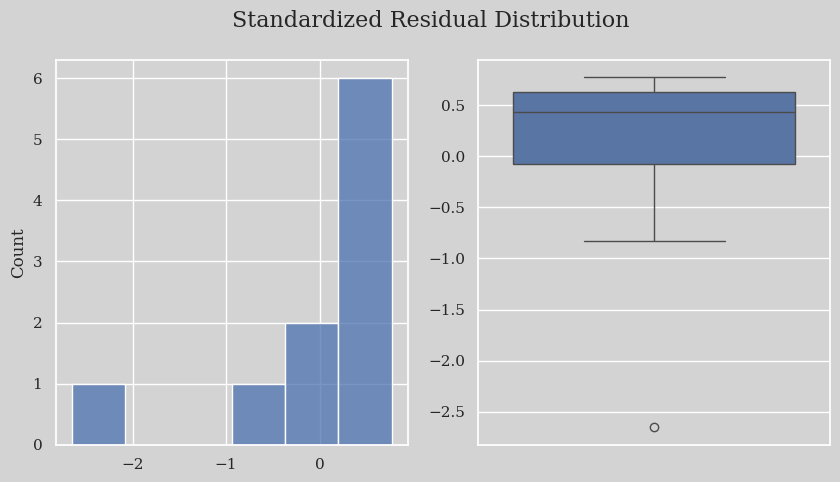

In [41]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(10,5))

sns.histplot(standardized_resid_sorted, ax=ax[0])
sns.boxplot(y=standardized_resid_sorted, ax=ax[1])
fig.suptitle('Standardized Residual Distribution', fontsize=16)

Both plots consistently suggest that the residuals are negatively skewed and contain at least one outlier on the negative side. This is not characteristic of a normal distribution.

#### Homoscedasticity

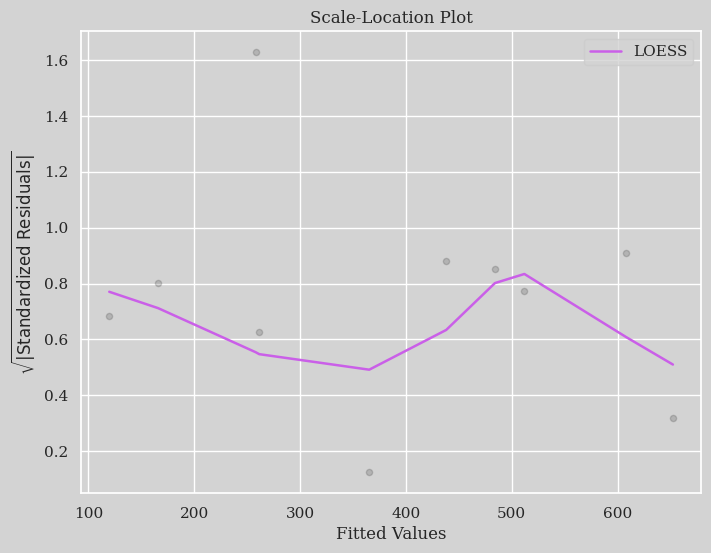

In [42]:
abs_standardized_resid = np.abs(standardized_resid)
sqrt_abs_standardized_resid = np.sqrt(abs_standardized_resid)

fig, ax = plt.subplots(ncols=1, figsize=(8, 6))
sns.regplot(x=model.predict(),
            y=sqrt_abs_standardized_resid,
            ax=ax,
            scatter_kws={'alpha': 0.15, 'color': 'black', 's': 20}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False    
           )

ax.set_title('Scale-Location Plot')
ax.set_xlabel('Fitted Values') 
ax.set_ylabel(r'$\sqrt{|\text{Standardized Residuals}|}$')

plt.legend()
plt.show()

LOESS line is clearly not flat! Indicating a violation in Equality in Variance.

#### Indendependence of Observed Values

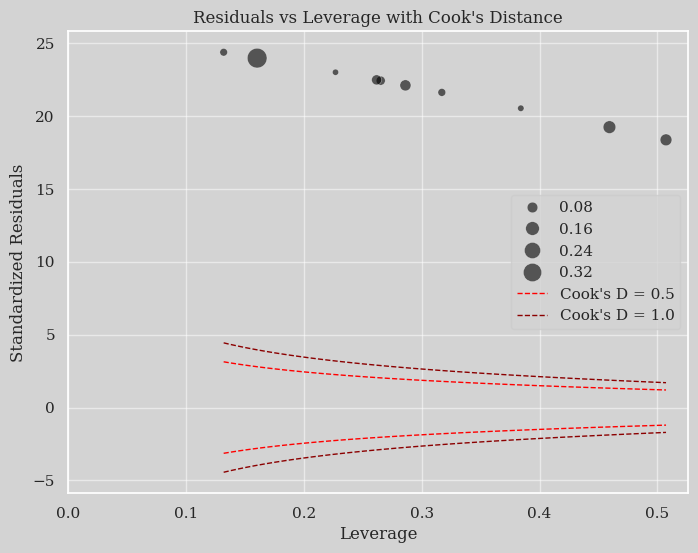

In [43]:
influence = model.get_influence()

standardized_resid = influence.resid_std
leverage_values = influence.hat_matrix_diag
cooks_distance = influence.cooks_distance[0] 


fig, ax = plt.subplots(ncols=1, figsize=(8, 6))

sns.scatterplot(x=leverage_values,
                y=standardized_resid,
                size=cooks_distance,
                sizes=(20, 200),
                alpha=0.6,
                color='black',
                legend="brief", 
                ax=ax)


num_params = model.df_model + 1

leverage_plot = np.linspace(leverage_values.min(), leverage_values.max(), 100)
leverage_plot = leverage_plot[(leverage_plot > 0) & (leverage_plot < 1)]

def cooks_threshold_y(cooks_d, leverage, num_params):
    h_ii_safe = leverage + np.finfo(float).eps # to avoid division by 0

    one_minus_h_ii_safe = (1 - leverage) + np.finfo(float).eps
    
    numerator = cooks_d * num_params * one_minus_h_ii_safe
    denominator = h_ii_safe
    
    y_squared = np.divide(numerator, denominator, out=np.full_like(numerator, np.nan), where=denominator!=0)
    y_squared[y_squared < 0] = 0 

    return np.sqrt(y_squared)

cooks_d_threshold1 = 0.5
cooks_d_threshold2 = 1.0

y_threshold1 = cooks_threshold_y(cooks_d_threshold1, leverage_plot, num_params)
y_threshold2 = cooks_threshold_y(cooks_d_threshold2, leverage_plot, num_params)

ax.plot(leverage_plot, y_threshold1, label=f"Cook's D = {cooks_d_threshold1}", color='red', linestyle='--', lw=1)
ax.plot(leverage_plot, -y_threshold1, color='red', linestyle='--', lw=1)
ax.plot(leverage_plot, y_threshold2, label=f"Cook's D = {cooks_d_threshold2}", color='darkred', linestyle='--', lw=1)
ax.plot(leverage_plot, -y_threshold2, color='darkred', linestyle='--', lw=1) 


ax.set_title("Residuals vs Leverage with Cook's Distance") 
ax.set_ylabel('Standardized Residuals')
ax.set_xlabel('Leverage')
ax.set_xlim(left=0)

ax.legend()

plt.grid(True, linestyle='-', alpha=0.5)
plt.show()

All the assumptions are violated. This is therefore not a very good linear model since it may result to bias estimates and invalid inference. Of course, there are plenty of options as to how to continue:

1. Introducing new terms (like polynomial terms) - maybe the relationship isn't linear at all.
2. Transform variables - the model may not be as vindictive to other space.
3. Apply either, GLS or WLS to address for unequal variance.

Since all assumptions are violated, adding to the fact that sample size is sparse with n=10, this linear model although have a high Adj. R-Sq = 0.98, isn't a reliable model. 

---

##  Monthly Sales and Advertising

In [44]:
df2 = pd.read_csv("Monthly Sales and Ad.csv")
print(df2.info())
df2

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   Month       12 non-null     int64
 1   TV_Ad ($k)  12 non-null     int64
 2   Sales ($k)  12 non-null     int64
dtypes: int64(3)
memory usage: 420.0 bytes
None


,Month,TV_Ad ($k),Sales ($k)
0,1,210,640
1,2,200,615
2,3,195,590
3,4,210,620
4,5,220,655
5,6,225,670
6,7,230,680
7,8,240,700
8,9,235,690
9,10,245,710


In [45]:
response = 'Sales ($k)' 
Y = df2[response]
X = df2.drop(columns=response)
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
y_pred = model.predict()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sales ($k)   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     552.9
Date:                Fri, 19 Sep 2025   Prob (F-statistic):           3.82e-10
Time:                        22:16:56   Log-Likelihood:                -34.074
No. Observations:                  12   AIC:                             74.15
Df Residuals:                       9   BIC:                             75.60
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         43.4167     44.774      0.970      0.358     -57.869     144.702
Month         -2.9975      1.317     -2.276      0.049      -5.977      -0.018
TV_Ad ($k)     2.8521      0.233     12.236      0.000       2.325       3.379
==============================================================================
Omnibus:                        5.732   Durbin-Watson:                   2.098
Prob(Omnibus):                  0.057   Jarque-Bera (JB):                2.255
Skew:                          -0.889   Prob(JB):                        0.324
Kurtosis:                       4.162   Cond. No.                     7.39e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.39e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

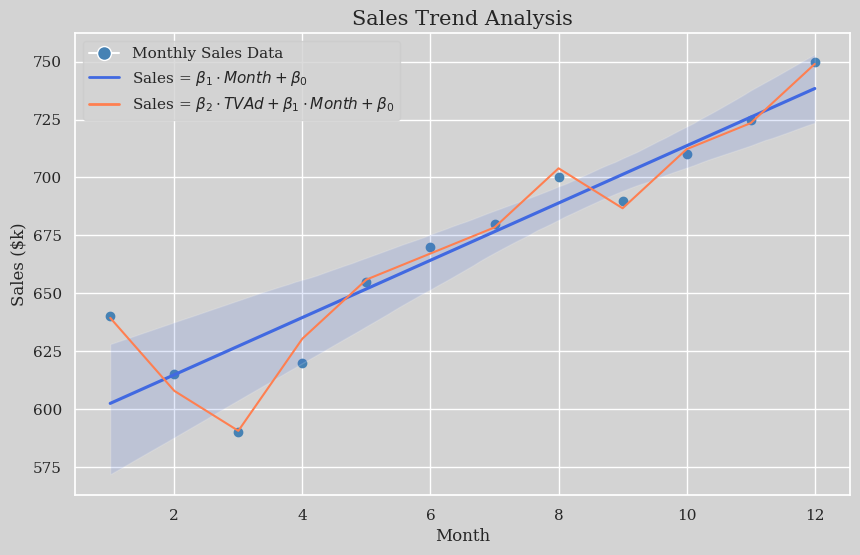

In [46]:
fig, ax = plt.subplots(figsize=(10, 6))

scatter = ax.scatter(df2['Month'], df2['Sales ($k)'], color='steelblue')

reg = sns.regplot(x=df2['Month'], y=df2['Sales ($k)'], 
            scatter=False,  # Turn off scatter to avoid duplicating points
            line_kws={'color': 'royalblue'},
            ax=ax)

pred = sns.lineplot(x=df2['Month'],
             y=y_pred,
             ax=ax,
             color='coral')  

plt.title('Sales Trend Analysis', size=15)
plt.xlabel('Month')
plt.ylabel('Sales ($k)')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=10, label='Monthly Sales Data'),
    Line2D([0], [0], color='royalblue', lw=2, label=r'Sales = $\beta_1 \cdot Month + \beta_0$'),
    Line2D([0], [0], color='coral', lw=2, label=r'Sales = $\beta_2 \cdot TVAd + \beta_1 \cdot Month + \beta_0$')
]

ax.legend(handles=legend_elements)

plt.show()

The Simple Linear Regression (blue line) only shows a linear trend of the `Sales` with regards to `Month`. Basing on the grap, the overall trend is rather significant. --reinforcing the low p-value (p=0.049) from the summary of multiple linear regression above. However, when we also take the `TV Ad`, the model performed even better, following the data points rather closely. 

In [81]:
from statsmodels.stats.stattools import durbin_watson
Y = df2[response]
X = df2.drop(columns=response)
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print("K =", len(model.params) - 1) # exclude the intercept
print("N =", len(Y))
residuals = model.resid

dw_statistic = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_statistic}")

K = 2
N = 12
Durbin-Watson statistic: 2.0982139811921203


According to the [reference](https://www3.nd.edu/~wevans1/econ30331/durbin_watson_tables.pdf
), the dL and dU for a Durbin-Watson statistic with n=12 and k=2 are:
- dL = 0.569
- dU = 1.274

$H_0$ : No autocorrelations

Decision:

Since $DW \approx 2.098 > 1.274 \approx dU$, we fail to reject the null-hypothesis ($H_0$). Therefore, there exist no autocorrelations.



##### Implications on the Model
Since we have fail to reject the null-hypthesis we have met an important assumption in regression analysis of "no autocorrelations." This ought to increase the model's validity in terms of its standard errors, hypothesis tests, confidence interval, and its overall efficiency. 

Although it is wise to take the result of Durbin-Watson with a grain of salt since Durbin-Watson have small sample bias ([Spencer, 1975](https://www.sciencedirect.com/science/article/abs/pii/0304407675900342)). Let us display ACF and PACF as a complement to the result.

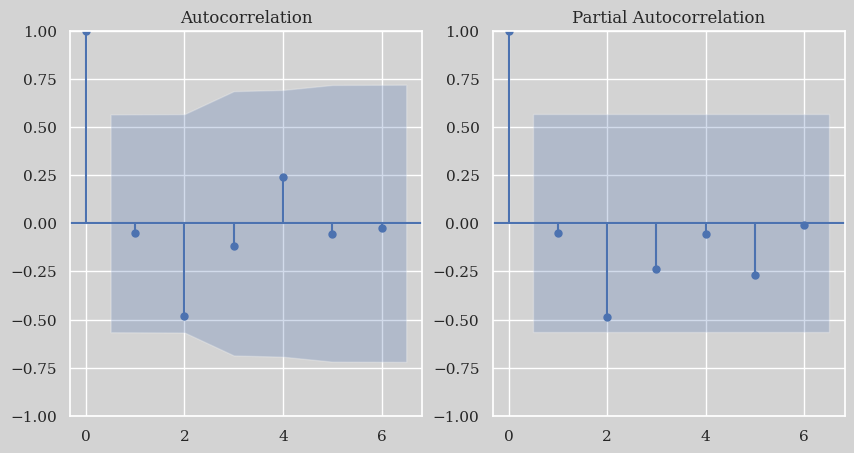

In [82]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(ncols=2, figsize=(10,5))

axes = axes.flatten()

plot_acf(residuals, ax=axes[0])

plot_pacf(residuals, ax=axes[1]);

Both ACF and PACF reinforced the conclusion in Durbin-Watson test that there was not first-order correlation. 

*What if there was a autocorrelation?*
In models with positive autocorrelation, OLS typically underestimates standard errors, making coefficients appear more significant than they truly are. 

*What if we apply a correction method such as Cochrane-Orcutt Method?*
- Coefficient Estimate will become more reliable and the standard errors become more realistic.
- Statistical significance in the original model may change in the corrected model.
- Adj R2 will reflect a more accurate model fit because the corrected model has a more honest assessment of the explanatory power.

Overall, the model become more reliable and thus more fitted for a basis of various business decision and inference.


---

### Sales with Heteroscedasticity

In [49]:
df3 = pd.read_csv("Sales Hetero.csv")
print(df3.info())
df3.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12 entries, 0 to 11
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Month             12 non-null     int64
 1   Advertising ($k)  12 non-null     int64
 2   Sales ($k)        12 non-null     int64
dtypes: int64(3)
memory usage: 420.0 bytes
None


,Month,Advertising ($k),Sales ($k)
0,1,30,114
1,2,35,143
2,3,40,152
3,4,45,185
4,5,50,198


In [50]:
response = "Sales ($k)"
predictor = "Advertising ($k)"
Y = df3[response]
X = df3[predictor]
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sales ($k)   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     399.8
Date:                Fri, 19 Sep 2025   Prob (F-statistic):           2.15e-09
Time:                        22:16:57   Log-Likelihood:                -51.602
No. Observations:                  12   AIC:                             107.2
Df Residuals:                      10   BIC:                             108.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -11.4494     14.713     -0.778      0.454     -44.232      21.333
Advertising ($k)     4.2070      0.210     19.994      0.000       3.738       4.676
==============================================================================
Omnibus:                        2.129   Durbin-Watson:                   3.377
Prob(Omnibus):                  0.345   Jarque-Bera (JB):                1.044
Skew:                          -0.719   Prob(JB):                        0.593
Kurtosis:                       2.855   Cond. No.                         182.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

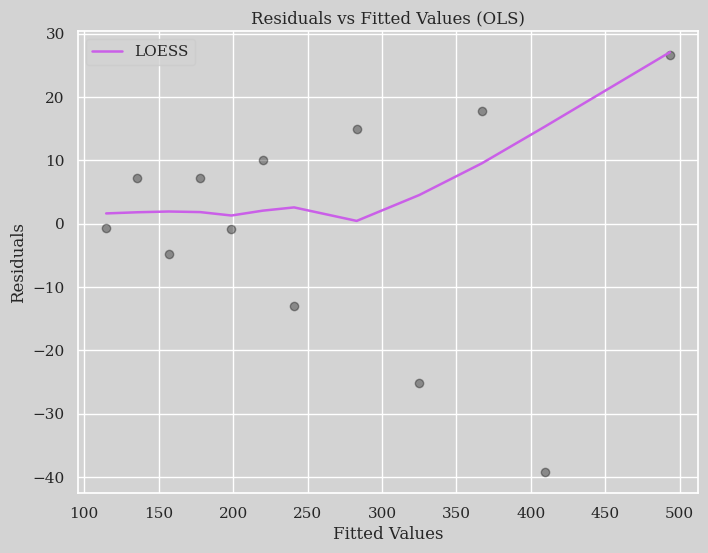

In [51]:
import matplotlib.pyplot as plt


plt.figure(figsize=(8, 6))

sns.regplot(x=model.predict(), 
            y=model.resid, 
            scatter_kws={'alpha':0.35, 'color' : "black"}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False)

plt.title('Residuals vs Fitted Values (OLS)')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()

plt.show()

Ideally speaking, we want the LOESS line to be a relatively flat line hovering around 0. However, the LOESS line shown above increases approximately linearly from `fitted values = 250` onwards. This flag a potential heteroscedasticity where the spread of residuals increases as the fitted values get larger. 

Let us use Weighted Least Squares (WLS)  to adress heteroscedasticity.

In [52]:
response = "Sales ($k)"
predictor = "Advertising ($k)"
Y = df3[response]
X = df3[predictor]
X = sm.add_constant(X)
model_ols = sm.OLS(Y, X).fit()
model_ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sales ($k)   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     399.8
Date:                Fri, 19 Sep 2025   Prob (F-statistic):           2.15e-09
Time:                        22:16:57   Log-Likelihood:                -51.602
No. Observations:                  12   AIC:                             107.2
Df Residuals:                      10   BIC:                             108.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -11.4494     14.713     -0.778      0.454     -44.232      21.333
Advertising ($k)     4.2070      0.210     19.994      0.000       3.738       4.676
==============================================================================
Omnibus:                        2.129   Durbin-Watson:                   3.377
Prob(Omnibus):                  0.345   Jarque-Bera (JB):                1.044
Skew:                          -0.719   Prob(JB):                        0.593
Kurtosis:                       2.855   Cond. No.                         182.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In terms of Business Logic, it's often reasonable to assume that the higher advertising budget, the more variable are the sales. So this is a good place to start.

Text(0.5, 1.0, 'Sales vs Advertising')

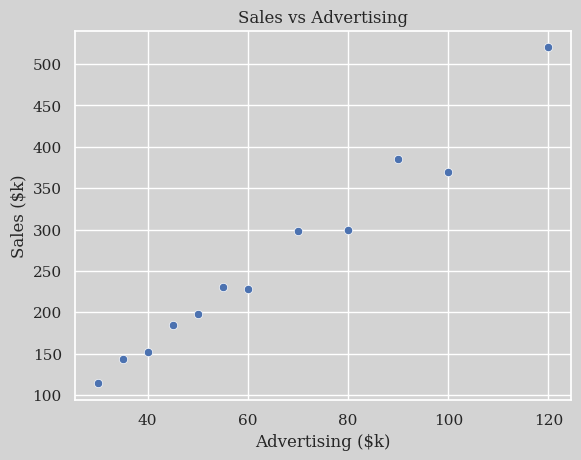

In [53]:
sns.scatterplot(x=X[predictor], y=Y)

plt.title("Sales vs Advertising")

As we can see, majority of data points cluster around $\leq 60$ advertsing and $<50$ sales. Then the difference in sales between each data points increases as the advertising becomes larger.

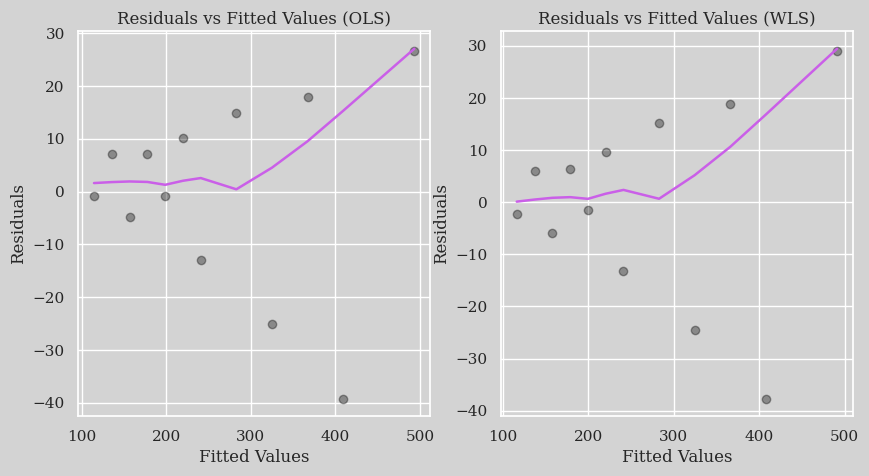

<Figure size 800x600 with 0 Axes>

In [54]:
response = "Sales ($k)"
predictor = "Advertising ($k)"
Y = df3[response]
X = df3[predictor]
X = sm.add_constant(X)
model_ols = sm.OLS(Y, X).fit()

weights = 1 / (model_ols.fittedvalues)
    
model_wls = sm.WLS(Y, X, weights=weights).fit()
# model_wls.summary()

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10,5))


plt.figure(figsize=(8, 6))

sns.regplot(x=model_ols.predict(), 
            y=model_ols.resid, 
            scatter_kws={'alpha':0.35, 'color' : "black"}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False,
            ax=axes[0])

axes[0].set_title('Residuals vs Fitted Values (OLS)')
axes[0].set_xlabel('Fitted Values')
axes[0].set_ylabel('Residuals')


sns.regplot(x=model_wls.predict(), 
            y=model_wls.resid, 
            scatter_kws={'alpha':0.35, 'color' : "black"}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False,
            ax=axes[1])

axes[1].set_title('Residuals vs Fitted Values (WLS)')
axes[1].set_xlabel('Fitted Values')
axes[1].set_ylabel('Residuals')

plt.show();

For some reason, any WLS weight result to minimal change in the LOESS curve. This might indicate that may heterestadicity isn't the issue after all. Nonetheless, let's choose to proceed with comparison between OLS and WLS.

In [55]:
def compare_ols_wls(ols_model, wls_model):
    # Create a simple comparison DataFrame
    comparison = pd.DataFrame({
        'OLS': [
            ols_model.params['const'],
            ols_model.params[predictor],
            ols_model.bse['const'],
            ols_model.bse[predictor],
            ols_model.pvalues['const'],
            ols_model.pvalues[predictor],
            # Model Fit
            ols_model.rsquared,
            ols_model.rsquared_adj,
            ols_model.aic,
            ols_model.fvalue
        ],
        'WLS': [
            wls_model.params['const'],
            wls_model.params[predictor],
            wls_model.bse['const'],
            wls_model.bse[predictor],
            # P-values
            wls_model.pvalues['const'],
            wls_model.pvalues[predictor],
            wls_model.rsquared,
            wls_model.rsquared_adj,
            wls_model.aic,
            wls_model.fvalue
        ]
    }, index=[
        'const_coef', 
        f'{predictor}_coef',
        'const_se',
        f'{predictor}_se',
        'const_pvalue',
        f'{predictor}_pvalue',
        'R-squared',
        'Adj. R-squared',
        'AIC',
        'F-statistic'
    ])
    
    return comparison.round(4)

comparison = compare_ols_wls(model_ols, model_wls)
print(comparison)

                              OLS       WLS
const_coef               -11.4494   -8.6525
Advertising ($k)_coef      4.2070    4.1637
const_se                  14.7131   11.0909
Advertising ($k)_se        0.2104    0.1885
const_pvalue               0.4545    0.4534
Advertising ($k)_pvalue    0.0000    0.0000
R-squared                  0.9756    0.9799
Adj. R-squared             0.9732    0.9779
AIC                      107.2041  102.3035
F-statistic              399.7626  487.6391


*Assuming that WLS worked, although it does not.*

To address the Heteroscedasticity, WLS was used with weight of `1/(Advertising)` by suspection of increased in variance with higher advertising values. With such correction implemented, we have gotten a more reliable parameter estimates. Notably:

1. Slightly lower `Advertising ($k)_coef` from OLS to WLS, $4.2070 \to 4.1637$. This suggests a minor overestimation of the coefficient in OLS.

2. Lower standard error in intercept - from $14.7131 \to 11.0909$, representing about a 25% reduction in uncertainty.

3. Higher R-Squared and Lower AIC - R-squared improved from $0.9756 \to 0.9799$ and AIC decreased from $107.2041 \to 102.3035$, indicating better model fit with WLS.

4. Lower standard error in `Advertising ($k)_coef` - $0.2104 \to 0.1885$. This reduction in SE along with the maintained p-value of 0.0000 suggests more precise estimation of the advertising effect.

Assuming there is indeed heteroscedasticity, the WLS model gives more reliable inference for prediction across the entire range of advertising values. The improved R-squared, lower AIC, and reduced standard errors all suggest that WLS is providing both better fit and more precise estimates. For business decision-making, the WLS model likely provides more accurate and reliable estimates for planning advertising budgets.

**Testing for Homoscedasticity**

To be more precise however, let us conduct a non-parametric test named "Spearmanr" to test for Homoscedasticity:

In [56]:
from scipy.stats import spearmanr
spearman_corr, p_value = spearmanr(abs(model_ols.resid), X[predictor])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {p_value:.4f}")

Spearman correlation: 0.9231, p-value: 0.0000


A Spearmanr test non-parametric test was conducted to test for Homoscedasticity. With p < 0.05, we reject the null hypothesis of homoscedasticity. The correlation (0.9231) might suggest that the variance of residuals increases almost proportionally with advertising spending, indicating a strong linear relationship between the predictor and error variance.

However, according to the Residual vs Fitted Values of the WLS model, there was barely any changes in the pattern. This tells us that the primary issue was model misspecification (needing  non-linear terms) rather than heteroscedasticity for changing weighing scale didn't solve the problem. 


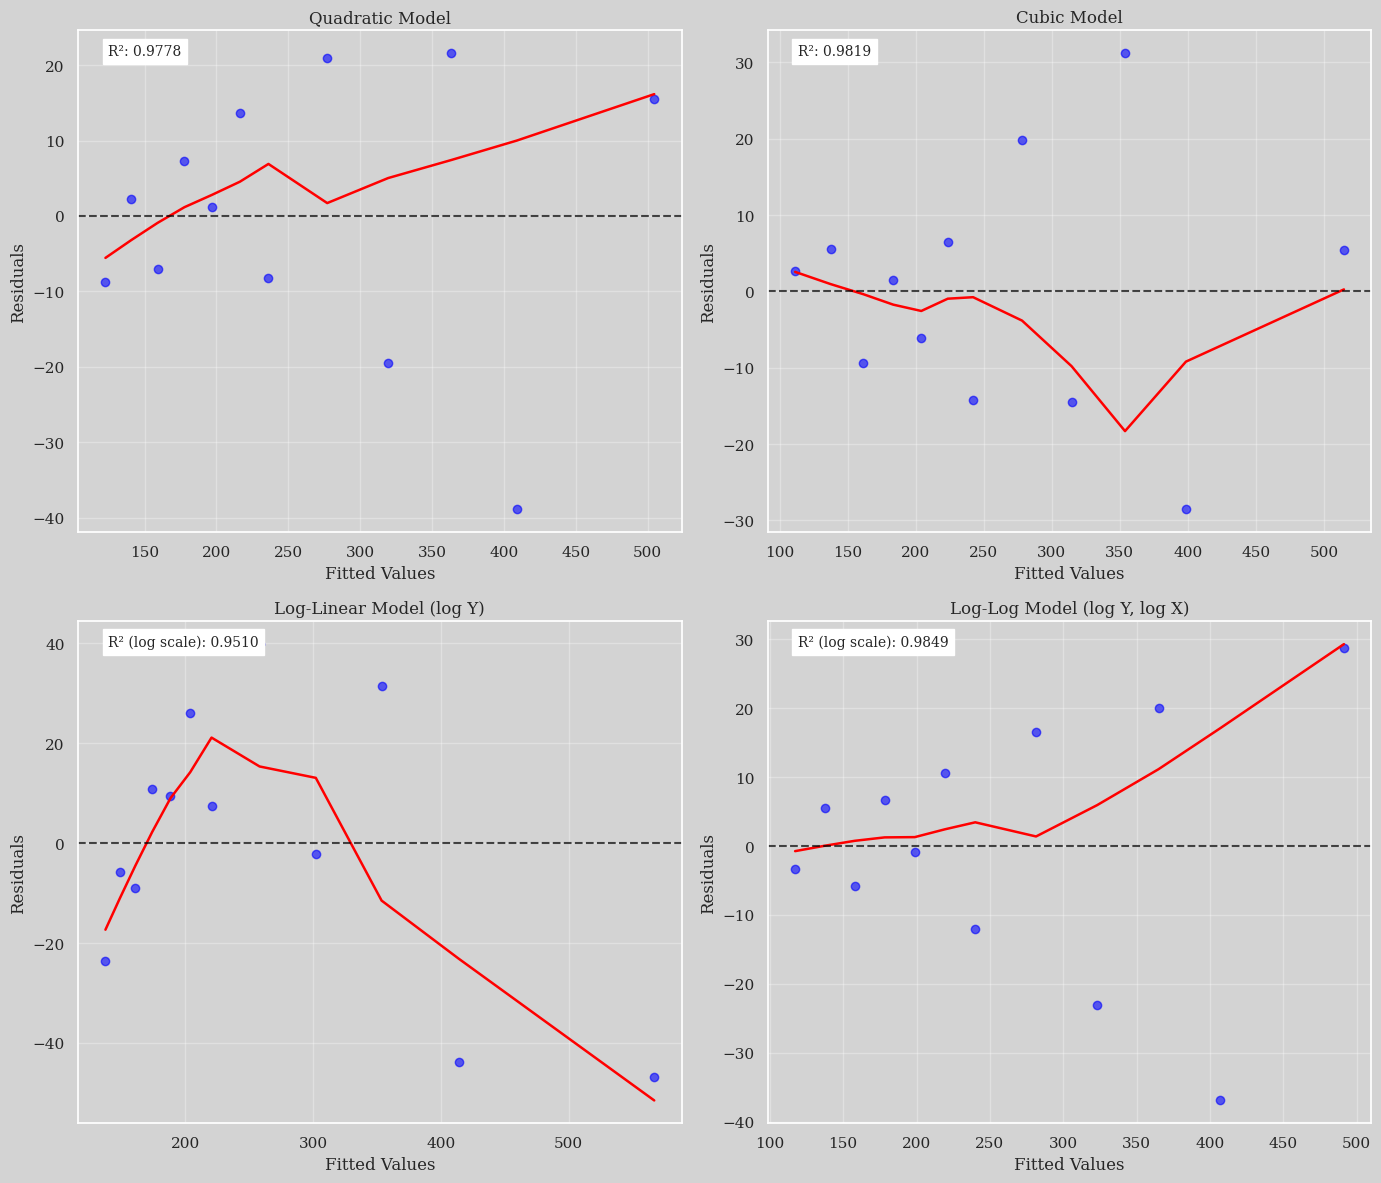

In [57]:
import statsmodels.formula.api as smf

df_clean = df3.copy()
df_clean.rename(columns={'Sales ($k)': 'Sales', 'Advertising ($k)': 'Advertising'}, inplace=True)

model_quad = smf.ols(formula='Sales ~ Advertising + I(Advertising**2)', data=df_clean).fit()
model_cubic = smf.ols(formula='Sales ~ Advertising + I(Advertising**2) + I(Advertising**3)', data=df_clean).fit()
model_log_y = smf.ols(formula='np.log(Sales) ~ Advertising', data=df_clean).fit()
model_log_log = smf.ols(formula='np.log(Sales) ~ np.log(Advertising)', data=df_clean).fit()


fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# 1. Quadratic Model (top-left)
ax1 = axes[0, 0]
sns.regplot(x=model_quad.fittedvalues, y=model_quad.resid, 
            scatter_kws={'alpha': 0.6, 'color': 'blue'}, 
            line_kws={'color': 'red', 'linewidth': 1.8},
            lowess=True, ci=False, ax=ax1)
ax1.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax1.set_xlabel('Fitted Values')
ax1.set_ylabel('Residuals')
ax1.set_title('Quadratic Model')
ax1.annotate(f"R²: {model_quad.rsquared:.4f}", xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=10, backgroundcolor='white')
ax1.grid(True, alpha=0.3)

# 2. Cubic Model (top-right)
ax2 = axes[0, 1]
sns.regplot(x=model_cubic.fittedvalues, y=model_cubic.resid, 
            scatter_kws={'alpha': 0.6, 'color': 'blue'}, 
            line_kws={'color': 'red', 'linewidth': 1.8},
            lowess=True, ci=False, ax=ax2)
ax2.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax2.set_xlabel('Fitted Values')
ax2.set_ylabel('Residuals')
ax2.set_title('Cubic Model')
ax2.annotate(f"R²: {model_cubic.rsquared:.4f}", xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=10, backgroundcolor='white')
ax2.grid(True, alpha=0.3)

# 3. Log-Linear Model (bottom-left)
ax3 = axes[1, 0]
# For log models, transform predictions back to original scale
fitted_values_log_y = np.exp(model_log_y.fittedvalues)
residuals_log_y = df_clean['Sales'] - fitted_values_log_y
sns.regplot(x=fitted_values_log_y, y=residuals_log_y, 
            scatter_kws={'alpha': 0.6, 'color': 'blue'}, 
            line_kws={'color': 'red', 'linewidth': 1.8},
            lowess=True, ci=False, ax=ax3)
ax3.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax3.set_xlabel('Fitted Values')
ax3.set_ylabel('Residuals')
ax3.set_title('Log-Linear Model (log Y)')
ax3.annotate(f"R² (log scale): {model_log_y.rsquared:.4f}", xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=10, backgroundcolor='white')
ax3.grid(True, alpha=0.3)

# 4. Log-Log Model (bottom-right)
ax4 = axes[1, 1]
# For log models, transform predictions back to original scale
fitted_values_log_log = np.exp(model_log_log.fittedvalues)
residuals_log_log = df_clean['Sales'] - fitted_values_log_log
sns.regplot(x=fitted_values_log_log, y=residuals_log_log, 
            scatter_kws={'alpha': 0.6, 'color': 'blue'}, 
            line_kws={'color': 'red', 'linewidth': 1.8},
            lowess=True, ci=False, ax=ax4)
ax4.axhline(y=0, color='black', linestyle='--', alpha=0.7)
ax4.set_xlabel('Fitted Values')
ax4.set_ylabel('Residuals')
ax4.set_title('Log-Log Model (log Y, log X)')
ax4.annotate(f"R² (log scale): {model_log_log.rsquared:.4f}", xy=(0.05, 0.95), xycoords='axes fraction', 
             fontsize=10, backgroundcolor='white')
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


Quadratic Model seemed to be the most behaved and have improved the linear model we had earlier. Although there were still some curvature in LOESS line, we can say that additional non-linear terms resulted better than WLS (that addresses heteroscedasticity). Note that: the curvature still present may be result of other cause like for example, a rather persistent and obvious outlier. But for the sake of this exercise let us proceed with the quadratic model.

In [58]:
model_quad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     197.9
Date:                Fri, 19 Sep 2025   Prob (F-statistic):           3.64e-08
Time:                        22:16:59   Log-Likelihood:                -51.042
No. Observations:                  12   AIC:                             108.1
Df Residuals:                       9   BIC:                             109.5
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept              23.2813     39.865      0.584      0.574     -66.900     113.463
Advertising             3.0861      1.213      2.544      0.032       0.342       5.831
I(Advertising ** 2)     0.0077      0.008      0.938      0.373      -0.011       0.026
==============================================================================
Omnibus:                        2.193   Durbin-Watson:                   3.413
Prob(Omnibus):                  0.334   Jarque-Bera (JB):                1.005
Skew:                          -0.708   Prob(JB):                        0.605
Kurtosis:                       2.931   Cond. No.                     4.42e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.42e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

---

### Task 3.3

In [85]:
response = "Sales ($k)"
Y = df3[response]
X = df3.drop(columns=response)
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sales ($k)   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     117.3
Date:                Fri, 19 Sep 2025   Prob (F-statistic):           5.95e-07
Time:                        22:40:55   Log-Likelihood:                -51.041
No. Observations:                  12   AIC:                             110.1
Df Residuals:                       8   BIC:                             112.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  32.0267    237.621      0.135      0.896    -515.929     579.982
Month                   1.3440     35.935      0.037      0.971     -81.523      84.211
Advertising ($k)        2.7049     10.274      0.263      0.799     -20.987      26.397
Advertising_squared     0.0092      0.040      0.229      0.825      -0.083       0.101
==============================================================================
Omnibus:                        2.165   Durbin-Watson:                   3.426
Prob(Omnibus):                  0.339   Jarque-Bera (JB):                0.984
Skew:                          -0.701   Prob(JB):                        0.611
Kurtosis:                       2.934   Cond. No.                     2.51e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.51e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [67]:
response = "Sales ($k)"
Y = df3[response]
X = df3['Advertising ($k)']
X = sm.add_constant(X)
model_ad = sm.OLS(Y, X).fit()
model_ad.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Sales ($k)   R-squared:                       0.976
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     399.8
Date:                Fri, 19 Sep 2025   Prob (F-statistic):           2.15e-09
Time:                        22:23:47   Log-Likelihood:                -51.602
No. Observations:                  12   AIC:                             107.2
Df Residuals:                      10   BIC:                             108.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -11.4494     14.713     -0.778      0.454     -44.232      21.333
Advertising ($k)     4.2070      0.210     19.994      0.000       3.738       4.676
==============================================================================
Omnibus:                        2.129   Durbin-Watson:                   3.377
Prob(Omnibus):                  0.345   Jarque-Bera (JB):                1.044
Skew:                          -0.719   Prob(JB):                        0.593
Kurtosis:                       2.855   Cond. No.                         182.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

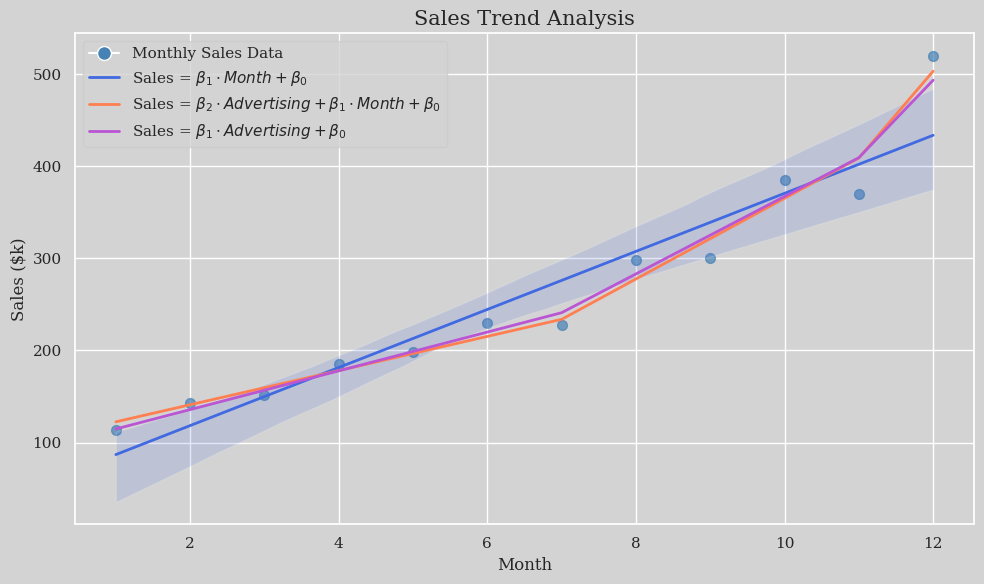

In [69]:
fig, ax = plt.subplots(figsize=(10, 6))

# Scatter plot of actual data
scatter = ax.scatter(df3['Month'], df3['Sales ($k)'], color='steelblue', s=50, alpha=0.7)

# Simple regression line (Month only)
reg_mo = sns.regplot(x=df3['Month'], y=df3['Sales ($k)'], 
            scatter=False,  # Turn off scatter to avoid duplicating points
            line_kws={'color': 'royalblue', 'linewidth': 2},
            ax=ax)

# Full model predictions (includes all predictors)
pred = sns.lineplot(x=df3['Month'],
             y=model.predict(),
             ax=ax,
             color='coral',
             linewidth=2)  

# Advertising-only model predictions
pred_ad = sns.lineplot(x=df3['Month'],
             y=model_ad.predict(),
             ax=ax,
             color='mediumorchid',
             linewidth=2) 

plt.title('Sales Trend Analysis', size=15)
plt.xlabel('Month')
plt.ylabel('Sales ($k)')

from matplotlib.lines import Line2D
legend_elements = [
    Line2D([0], [0], marker='o', color='w', markerfacecolor='steelblue', markersize=10, label='Monthly Sales Data'),
    Line2D([0], [0], color='royalblue', lw=2, label=r'Sales = $\beta_1 \cdot Month + \beta_0$'),
    Line2D([0], [0], color='coral', lw=2, label=r'Sales = $\beta_2 \cdot Advertising + \beta_1 \cdot Month + \beta_0$'),
    Line2D([0], [0], color='mediumorchid', lw=2, label=r'Sales = $\beta_1 \cdot Advertising + \beta_0$')
]

ax.legend(handles=legend_elements, loc='best')
plt.tight_layout()
plt.show()

When using the Month variable as the only predictor, it seems that we can infer the general trend of the Sales.

When using the Advertising as a sole predictor, however, fits better (although overfitting is questionable) and closly resembles the Sales data points.

Using both as predictors results to minimal improve from a simple linear model using Advertising as a predictor.

Technically, the model should have the 'Advertising' predictor but for the sake of time series analysis, we ought to use only the Month. Also, it could get tricky since we are tasked to forecast 3 months into the future. So, using 'Advertising' too can result to complex multivariate forecasting (Sales and Advertising forecasting simultanously) which is outside the score of this assessment.

In [100]:
from statsmodels.stats.stattools import durbin_watson

Y = df3[response]
X = df3['Month']
X = sm.add_constant(X)
model = sm.OLS(Y, X).fit()
print("K =", len(model.params) - 1)
print("N =", len(Y))
residuals = model.resid

dw_statistic = durbin_watson(residuals)
print(f"Durbin-Watson statistic: {dw_statistic}")

K = 1
N = 12
Durbin-Watson statistic: 1.6233917242386011


According to the [reference](https://www3.nd.edu/~wevans1/econ30331/durbin_watson_tables.pdf
), the dL and dU for a Durbin-Watson statistic with n=12 and k=2 are:
- dL = 0.697 
- dU = 1.023 

$H_0$ : No autocorrelations

Decision:

Since $DW \approx 1.623 > 1.023 \approx dU$, we fail to reject the null-hypothesis ($H_0$). Therefore, there exist no autocorrelations.

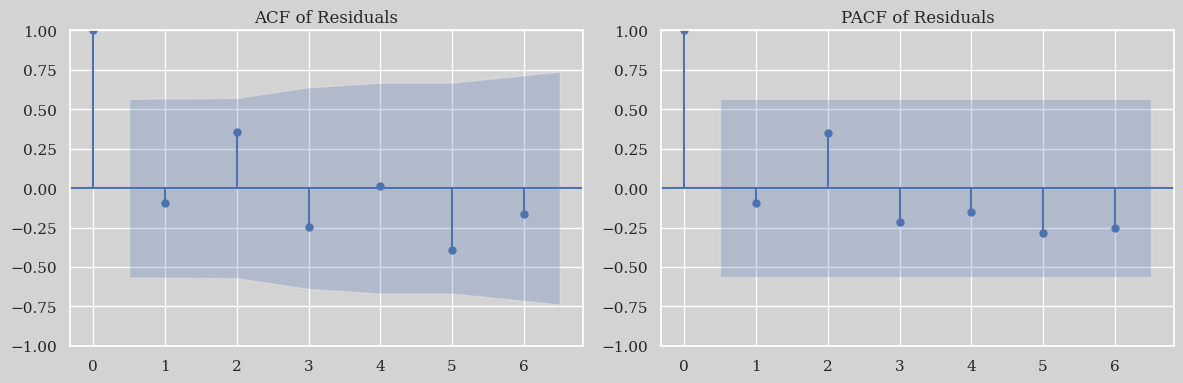

In [101]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

plot_acf(model.resid, lags=6, ax=axes[0])
axes[0].set_title('ACF of Residuals')

plot_pacf(model.resid, lags=6, ax=axes[1]) 
axes[1].set_title('PACF of Residuals')

plt.tight_layout()
plt.show()

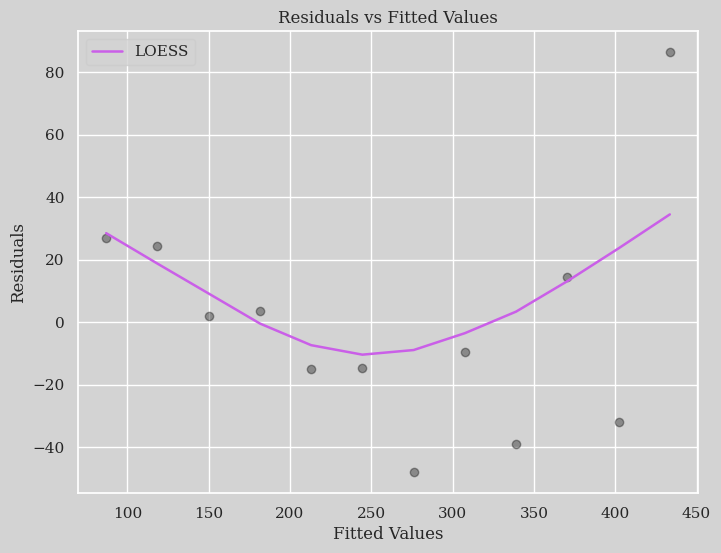

In [103]:
plt.figure(figsize=(8, 6))

sns.regplot(x=model.predict(), 
            y=model.resid, 
            scatter_kws={'alpha':0.35, 'color' : "black"}, 
            line_kws={'color': '#ca5fe8', "label" : "LOESS", "linewidth" : 1.8},
            lowess=True,
            ci=False)

plt.title('Residuals vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.legend()

plt.show()

In [105]:
from scipy.stats import spearmanr
spearman_corr, p_value = spearmanr(abs(model.resid), X["Month"])
print(f"Spearman correlation: {spearman_corr:.4f}, p-value: {p_value:.4f}")

Spearman correlation: 0.4196, p-value: 0.1745


No heterostadicity so  we may be missing non-linear term.

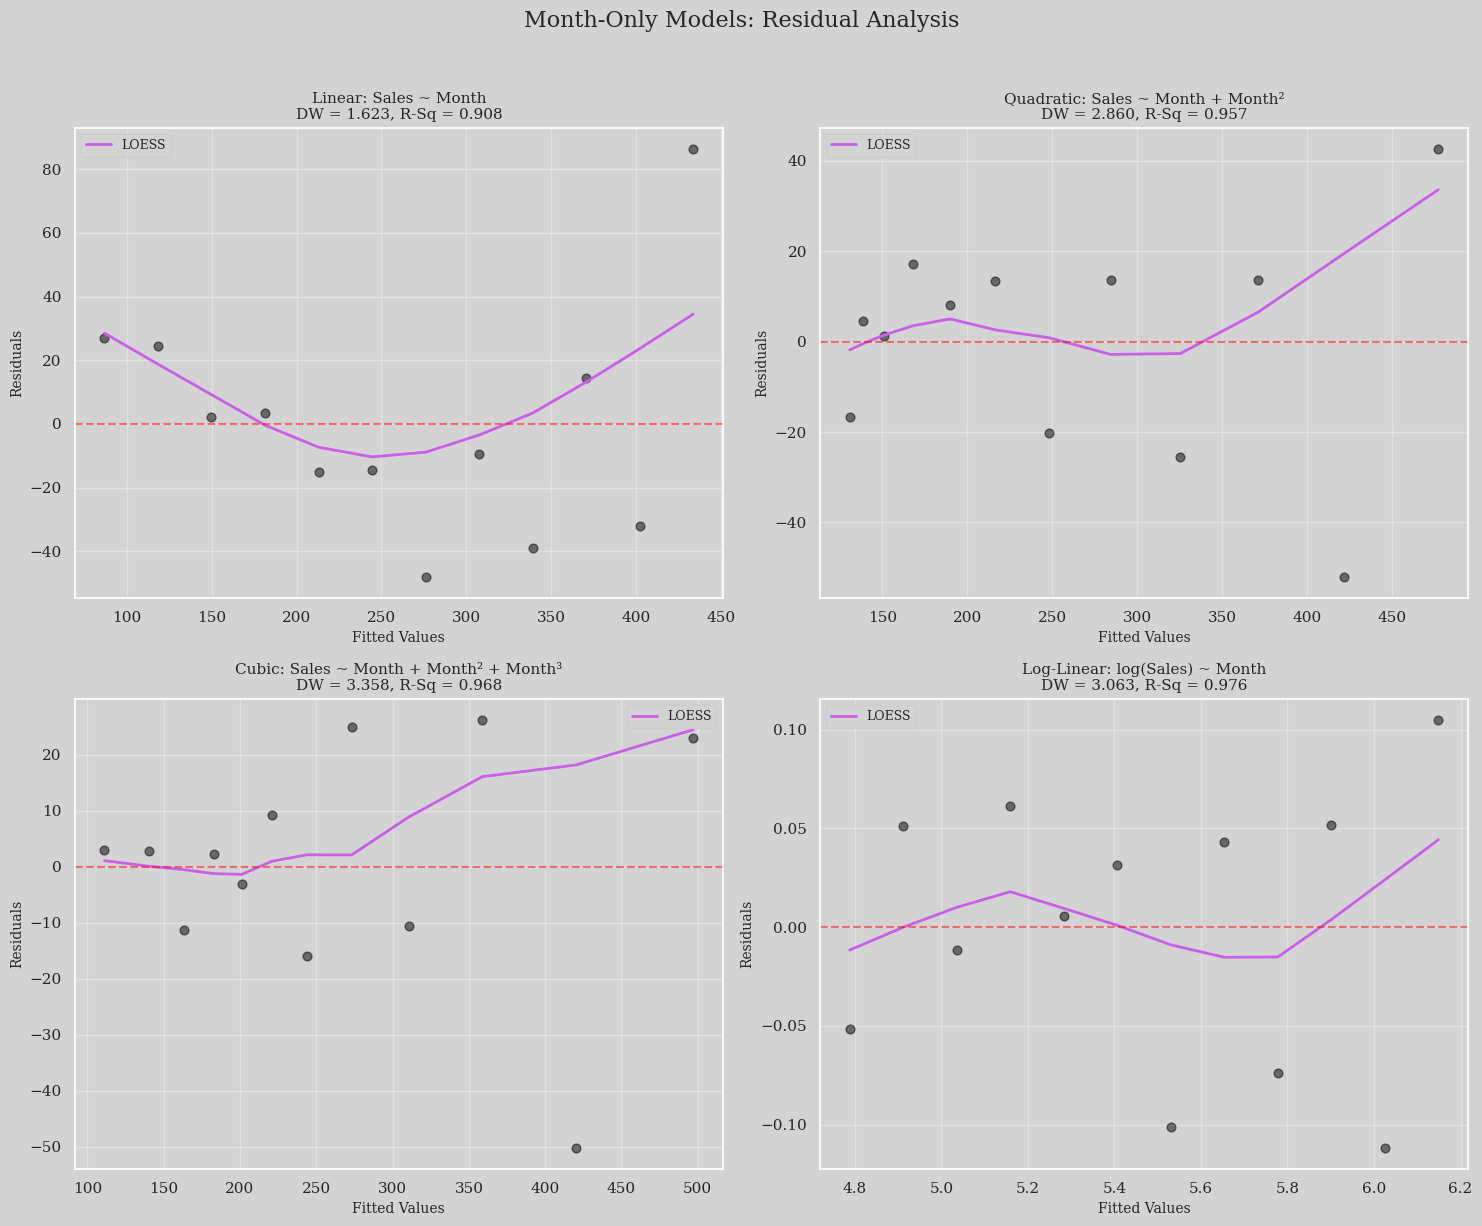

In [108]:
# 1. Linear Month
model_linear = sm.OLS(df3['Sales ($k)'], 
                      sm.add_constant(df3['Month'])).fit()

# 2. Quadratic Month
df3['Month_squared'] = df3['Month'] ** 2
model_quad = sm.OLS(df3['Sales ($k)'], 
                    sm.add_constant(df3[['Month', 'Month_squared']])).fit()

# 3. Cubic Month
df3['Month_cubed'] = df3['Month'] ** 3
model_cubic = sm.OLS(df3['Sales ($k)'], 
                     sm.add_constant(df3[['Month', 'Month_squared', 'Month_cubed']])).fit()

# 4. Log-linear model
model_log = sm.OLS(np.log(df3['Sales ($k)']), 
                   sm.add_constant(df3['Month'])).fit()

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(15, 12))
fig.suptitle('Month-Only Models: Residual Analysis', fontsize=16, y=1.02)

# Define models and titles
models = [model_linear, model_quad, model_cubic, model_log]
titles = ['Linear: Sales ~ Month', 
          'Quadratic: Sales ~ Month + Month²',
          'Cubic: Sales ~ Month + Month² + Month³',
          'Log-Linear: log(Sales) ~ Month']
dw_stats = [sm.stats.stattools.durbin_watson(m.resid) for m in models]

# Plot each model's residuals
for ax, model, title, dw in zip(axes.flat, models, titles, dw_stats):
    sns.regplot(x=model.predict(), 
                y=model.resid, 
                scatter_kws={'alpha':0.5, 'color': "black", 's': 40}, 
                line_kws={'color': '#ca5fe8', "label": "LOESS", "linewidth": 2},
                lowess=True,
                ci=False,
                ax=ax)
    
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.5)
    
    ax.set_title(f'{title}\nDW = {dw:.3f}, R-Sq = {model.rsquared:.3f}', fontsize=11)
    ax.set_xlabel('Fitted Values', fontsize=10)
    ax.set_ylabel('Residuals', fontsize=10)
    ax.legend(loc='best', fontsize=9)
    
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

So we have two choices here:
- Choose the quadratic model as safer choice.
- Choose the log-linear model but add a lag term (due to negative autocorellation presence)

Let us choose the latter for it has relatively flatter LOESS curve and we can remedy for autocorrelation adding a bit of sophistication to the model.

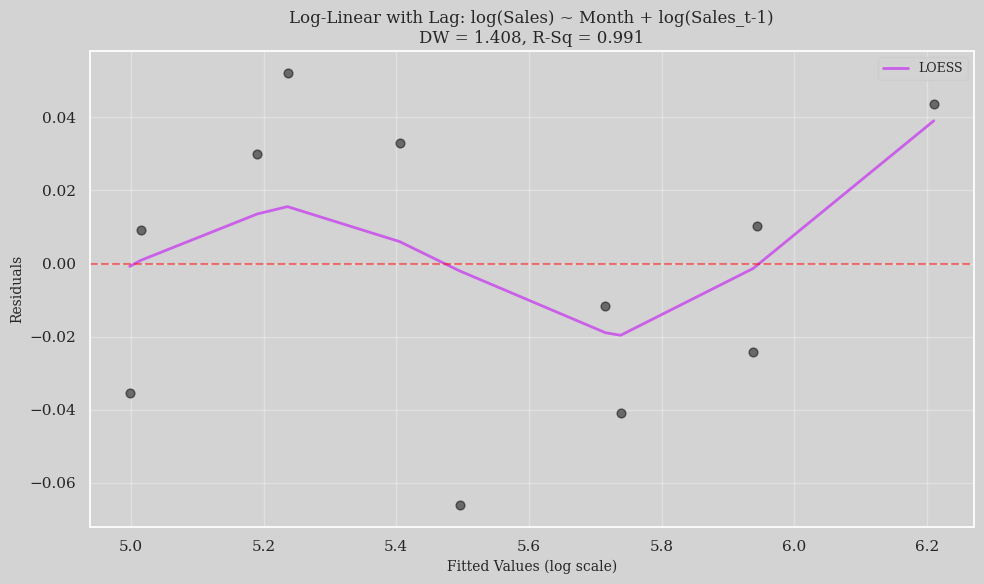

In [110]:
# Fit the log-linear model with lag
df3['Log_Sales'] = np.log(df3['Sales ($k)'])
df3['Log_Sales_lag1'] = df3['Log_Sales'].shift(1)

X_log_lag = sm.add_constant(df3[['Month', 'Log_Sales_lag1']].dropna())
Y_log_lag = df3['Log_Sales'][1:]
model_log_lag = sm.OLS(Y_log_lag, X_log_lag).fit()

dw_log_lag = sm.stats.stattools.durbin_watson(model_log_lag.resid)

plt.figure(figsize=(10, 6))

sns.regplot(x=model_log_lag.predict(), 
            y=model_log_lag.resid, 
            scatter_kws={'alpha':0.5, 'color': "black", 's': 40}, 
            line_kws={'color': '#ca5fe8', "label": "LOESS", "linewidth": 2},
            lowess=True,
            ci=False)

plt.axhline(y=0, color='red', linestyle='--', alpha=0.5)

plt.title(f'Log-Linear with Lag: log(Sales) ~ Month + log(Sales_t-1)\nDW = {dw_log_lag:.3f}, R-Sq = {model_log_lag.rsquared:.3f}', fontsize=12)
plt.xlabel('Fitted Values (log scale)', fontsize=10)
plt.ylabel('Residuals', fontsize=10)
plt.legend(loc='best', fontsize=9)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

There we go. Not only it has an outstanding fit of (0.991), it also solves the problem with autocorellation (DW=1.408) and relatively fix the problem with non-linearity. Time series wise, we captured both growth rate and momentum.

In [111]:
model_log_lag.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              Log_Sales   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     443.5
Date:                Fri, 19 Sep 2025   Prob (F-statistic):           6.38e-09
Time:                        23:11:52   Log-Likelihood:                 20.743
No. Observations:                  11   AIC:                            -35.49
Df Residuals:                       8   BIC:                            -34.29
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              9.0764      1.006      9.020      0.000       6.756      11.397
Month              0.2342      0.026      8.909      0.000       0.174       0.295
Log_Sales_lag1    -0.9600      0.220     -4.363      0.002      -1.467      -0.453
==============================================================================
Omnibus:                        1.025   Durbin-Watson:                   1.408
Prob(Omnibus):                  0.599   Jarque-Bera (JB):                0.708
Skew:                          -0.233   Prob(JB):                        0.702
Kurtosis:                       1.848   Cond. No.                         739.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

All predictors are significant too!

In [118]:
intercept = model_log_lag.params['const']
month_coef = model_log_lag.params['Month']
lag_coef = model_log_lag.params['Log_Sales_lag1']

last_log_sales = df3['Log_Sales'].iloc[-1]
last_month = df3['Month'].iloc[-1]

forecast_months = [13, 14, 15]
log_forecasts = []
sales_forecasts = []
previous_log = last_log_sales

for month in forecast_months:
    log_pred = intercept + month_coef * month + lag_coef * previous_log
    log_forecasts.append(log_pred)
    
    # convert (inverse) to actual sales
    sales_pred = np.exp(log_pred)
    sales_forecasts.append(sales_pred)
    
    # Update for next iteration
    previous_log = log_pred

# Create forecast dataframe
forecast_df = pd.DataFrame({
    'Month': forecast_months,
    'Log_Sales_Forecast': log_forecasts,
    'Sales_Forecast': sales_forecasts
})


se = np.sqrt(model_log_lag.mse_resid)

forecast_df['Sales_Lower_95'] = np.exp(forecast_df['Log_Sales_Forecast'] - 1.96*se)
forecast_df['Sales_Upper_95'] = np.exp(forecast_df['Log_Sales_Forecast'] + 1.96*se)


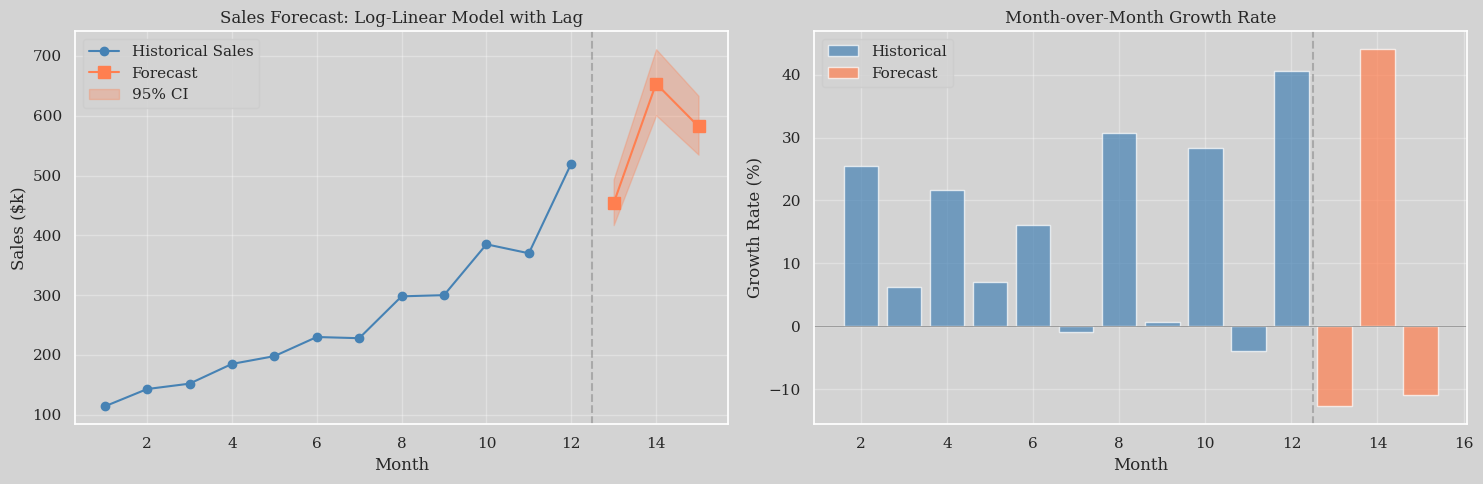

In [115]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# Plot 1: Historical + Forecast
ax1.plot(df3['Month'], df3['Sales ($k)'], 'o-', label='Historical Sales', color='steelblue', markersize=6)
ax1.plot(forecast_df['Month'], forecast_df['Sales_Forecast'], 's-', 
         label='Forecast', color='coral', markersize=8)
ax1.fill_between(forecast_df['Month'], 
                  forecast_df['Sales_Lower_95'], 
                  forecast_df['Sales_Upper_95'], 
                  alpha=0.3, color='coral', label='95% CI')
ax1.axvline(x=12.5, color='gray', linestyle='--', alpha=0.5)
ax1.set_xlabel('Month')
ax1.set_ylabel('Sales ($k)')
ax1.set_title('Sales Forecast: Log-Linear Model with Lag')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Growth Rate Analysis
historical_growth = df3['Sales ($k)'].pct_change() * 100
forecast_growth = pd.Series(sales_forecasts).pct_change() * 100

months_all = list(range(2, 13)) + [13, 14, 15]
growth_all = list(historical_growth[1:]) + [
    (sales_forecasts[0]/df3['Sales ($k)'].iloc[-1] - 1) * 100,
    forecast_growth.iloc[1],
    forecast_growth.iloc[2]
]

ax2.bar(months_all[:11], growth_all[:11], color='steelblue', alpha=0.7, label='Historical')
ax2.bar(months_all[11:], growth_all[11:], color='coral', alpha=0.7, label='Forecast')
ax2.axhline(y=0, color='gray', linestyle='-', linewidth=0.5)
ax2.axvline(x=12.5, color='gray', linestyle='--', alpha=0.5)
ax2.set_xlabel('Month')
ax2.set_ylabel('Growth Rate (%)')
ax2.set_title('Month-over-Month Growth Rate')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

According to our model, we will experience a drop in sales (compared to the previous month) for 13th and 15th month while the 14th month performance in sale will be the month that experiences the most growth!  

In [120]:
print("\n" + "="*50)
print("WITH 95% CONFIDENCE INTERVALS:")
print("="*50)
print(forecast_df[['Month', 'Sales_Forecast', 'Sales_Lower_95', 'Sales_Upper_95']].to_string(index=False))


WITH 95% CONFIDENCE INTERVALS:
 Month  Sales_Forecast  Sales_Lower_95  Sales_Upper_95
    13      453.825639      417.104105      493.780110
    14      653.676797      600.784204      711.226015
    15      582.039551      534.943522      633.281879


While the log-linear lag model fits historical data well ($R^2=0.991$), the forecasts show concerning volatility with sales spiking to $654k in Month 14 before declining. This pattern likely reflects model overfitting given the small sample size (n=11). I'm willing to guess that the cause of the sudden spike is the historically negative growth (Month 7 and 9 and 11) were followed by significantly higher sales. Now the reliability in terms of business planning is dependent on how they see this particular pattern. If sudden spikes aren't reliable for them, then it's not reliable. But if the business actually experiences these cyclical patterns, perhaps due to:
- Inventory cycles: Stockouts leading to pent-up demand
- Promotional calendars: Regular discount/premium pricing cycles
- Budget cycles: B2B customers with quarterly purchasing patterns
- Production constraints: Batch manufacturing creating supply waves

Then the model might be capturing a real business dynamic rather than statistical noise.

### Key Question to ask
1. Is there a business explanation for the oscillation?
- check what happened business wise during months 7,9, and 11
2. Does this pattern repeat in other years?
- With only 12 months, you can't verify if this is seasonal. Prior year data would reveal if this is systematic
3. What do stakeholders expect?
- Sales teams might confirm: "Yes, we do see these swings"
- Or they might say: "No, this volatility makes no sense"

This way, decision-makers can choose based on their domain knowledge rather than purely statistical metrics. The "best" model statistically ($R^2=0.991$) might not be the best model practically.

Simpler model might better like quadratic or other methods like Exponential Smoothing or even doing the advertising and conducting either multivariate forecasting or what if analysis where we assume some values of advertising with the use of domain knowledge.